In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
import gc
pd.set_option('display.max_columns', None)

In [2]:
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for plotting
import matplotlib.pyplot as plt
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import LabelEncoder,Normalizer,StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## for explainer
#from lime import lime_tabular

In [3]:
#CFS implementation
#Source: https://github.com/ZixiaoShen/Correlation-based-Feature-Selection

import scipy.spatial as ss
from scipy.special import digamma
from math import log
import numpy.random as nr
import numpy as np
import random


# continuous estimators

def entropy(x, k=3, base=2):
    """
    The classic K-L k-nearest neighbor continuous entropy estimator x should be a list of vectors,
    e.g. x = [[1.3],[3.7],[5.1],[2.4]] if x is a one-dimensional scalar and we have four samples
    """

    assert k <= len(x)-1, "Set k smaller than num. samples - 1"
    d = len(x[0])
    N = len(x)
    intens = 1e-10  # small noise to break degeneracy, see doc.
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    tree = ss.cKDTree(x)
    nn = [tree.query(point, k+1, p=float('inf'))[0][k] for point in x]
    const = digamma(N)-digamma(k) + d*log(2)
    return (const + d*np.mean(map(log, nn)))/log(base)


def mi(x, y, k=3, base=2):
    """
    Mutual information of x and y; x, y should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """

    assert len(x) == len(y), "Lists should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    intens = 1e-10  # small noise to break degeneracy, see doc.
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    y = [list(p + intens * nr.rand(len(y[0]))) for p in y]
    points = zip2(x, y)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = ss.cKDTree(points)
    dvec = [tree.query(point, k+1, p=float('inf'))[0][k] for point in points]
    a, b, c, d = avgdigamma(x, dvec), avgdigamma(y, dvec), digamma(k), digamma(len(x))
    return (-a-b+c+d)/log(base)


def cmi(x, y, z, k=3, base=2):
    """
    Mutual information of x and y, conditioned on z; x, y, z should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """

    assert len(x) == len(y), "Lists should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    intens = 1e-10  # small noise to break degeneracy, see doc.
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    y = [list(p + intens * nr.rand(len(y[0]))) for p in y]
    z = [list(p + intens * nr.rand(len(z[0]))) for p in z]
    points = zip2(x, y, z)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = ss.cKDTree(points)
    dvec = [tree.query(point, k+1, p=float('inf'))[0][k] for point in points]
    a, b, c, d = avgdigamma(zip2(x, z), dvec), avgdigamma(zip2(y, z), dvec), avgdigamma(z, dvec), digamma(k)
    return (-a-b+c+d)/log(base)


def kldiv(x, xp, k=3, base=2):
    """
    KL Divergence between p and q for x~p(x), xp~q(x); x, xp should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """

    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    assert k <= len(xp) - 1, "Set k smaller than num. samples - 1"
    assert len(x[0]) == len(xp[0]), "Two distributions must have same dim."
    d = len(x[0])
    n = len(x)
    m = len(xp)
    const = log(m) - log(n-1)
    tree = ss.cKDTree(x)
    treep = ss.cKDTree(xp)
    nn = [tree.query(point, k+1, p=float('inf'))[0][k] for point in x]
    nnp = [treep.query(point, k, p=float('inf'))[0][k-1] for point in x]
    return (const + d*np.mean(map(log, nnp))-d*np.mean(map(log, nn)))/log(base)


# Discrete estimators
def entropyd(sx, base=2):
    """
    Discrete entropy estimator given a list of samples which can be any hashable object
    """

    return entropyfromprobs(hist(sx), base=base)


def midd(x, y):
    """
    Discrete mutual information estimator given a list of samples which can be any hashable object
    """

    return -entropyd(list(zip(x, y)))+entropyd(x)+entropyd(y)


def cmidd(x, y, z):
    """
    Discrete mutual information estimator given a list of samples which can be any hashable object
    """

    return entropyd(list(zip(y, z)))+entropyd(list(zip(x, z)))-entropyd(list(zip(x, y, z)))-entropyd(z)


def hist(sx):
    # Histogram from list of samples
    d = dict()
    for s in sx:
        d[s] = d.get(s, 0) + 1
    return map(lambda z: float(z)/len(sx), d.values())


def entropyfromprobs(probs, base=2):
    # Turn a normalized list of probabilities of discrete outcomes into entropy (base 2)
    return -sum(map(elog, probs))/log(base)


def elog(x):
    # for entropy, 0 log 0 = 0. but we get an error for putting log 0
    if x <= 0. or x >= 1.:
        return 0
    else:
        return x*log(x)


# Mixed estimators
def micd(x, y, k=3, base=2, warning=True):
    """ If x is continuous and y is discrete, compute mutual information
    """

    overallentropy = entropy(x, k, base)
    n = len(y)
    word_dict = dict()
    for sample in y:
        word_dict[sample] = word_dict.get(sample, 0) + 1./n
    yvals = list(set(word_dict.keys()))

    mi = overallentropy
    for yval in yvals:
        xgiveny = [x[i] for i in range(n) if y[i] == yval]
        if k <= len(xgiveny) - 1:
            mi -= word_dict[yval]*entropy(xgiveny, k, base)
        else:
            if warning:
                print("Warning, after conditioning, on y={0} insufficient data. Assuming maximal entropy in this case.".format(yval))
            mi -= word_dict[yval]*overallentropy
    return mi  # units already applied


# Utility functions
def vectorize(scalarlist):
    """
    Turn a list of scalars into a list of one-d vectors
    """

    return [(x,) for x in scalarlist]


def shuffle_test(measure, x, y, z=False, ns=200, ci=0.95, **kwargs):
    """
    Shuffle test
    Repeatedly shuffle the x-values and then estimate measure(x,y,[z]).
    Returns the mean and conf. interval ('ci=0.95' default) over 'ns' runs, 'measure' could me mi,cmi,
    e.g. Keyword arguments can be passed. Mutual information and CMI should have a mean near zero.
    """

    xp = x[:]   # A copy that we can shuffle
    outputs = []
    for i in range(ns):
        random.shuffle(xp)
        if z:
            outputs.append(measure(xp, y, z, **kwargs))
        else:
            outputs.append(measure(xp, y, **kwargs))
    outputs.sort()
    return np.mean(outputs), (outputs[int((1.-ci)/2*ns)], outputs[int((1.+ci)/2*ns)])


# Internal functions
def avgdigamma(points, dvec):
    # This part finds number of neighbors in some radius in the marginal space
    # returns expectation value of <psi(nx)>
    N = len(points)
    tree = ss.cKDTree(points)
    avg = 0.
    for i in range(N):
        dist = dvec[i]
        # subtlety, we don't include the boundary point,
        # but we are implicitly adding 1 to kraskov def bc center point is included
        num_points = len(tree.query_ball_point(points[i], dist-1e-15, p=float('inf')))
        avg += digamma(num_points)/N
    return avg


def zip2(*args):
    # zip2(x,y) takes the lists of vectors and makes it a list of vectors in a joint space
    # E.g. zip2([[1],[2],[3]],[[4],[5],[6]]) = [[1,4],[2,5],[3,6]]
    return [sum(sublist, []) for sublist in zip(*args)]

In [4]:
def information_gain(f1, f2):
    """
    This function calculates the information gain, where ig(f1,f2) = H(f1) - H(f1|f2)
    Input
    -----
    f1: {numpy array}, shape (n_samples,)
    f2: {numpy array}, shape (n_samples,)
    Output
    ------
    ig: {float}
    """

    ig = entropyd(f1) - conditional_entropy(f1, f2)
    return ig


def conditional_entropy(f1, f2):
    """
    This function calculates the conditional entropy, where ce = H(f1) - I(f1;f2)
    Input
    -----
    f1: {numpy array}, shape (n_samples,)
    f2: {numpy array}, shape (n_samples,)
    Output
    ------
    ce: {float}
        ce is conditional entropy of f1 and f2
    """

    ce = entropyd(f1) - midd(f1, f2)
    return ce


def su_calculation(f1, f2):
    """
    This function calculates the symmetrical uncertainty, where su(f1,f2) = 2*IG(f1,f2)/(H(f1)+H(f2))
    Input
    -----
    f1: {numpy array}, shape (n_samples,)
    f2: {numpy array}, shape (n_samples,)
    Output
    ------
    su: {float}
        su is the symmetrical uncertainty of f1 and f2
    """

    # calculate information gain of f1 and f2, t1 = ig(f1,f2)
    t1 = information_gain(f1, f2)
    # calculate entropy of f1, t2 = H(f1)
    t2 = entropyd(f1)
    # calculate entropy of f2, t3 = H(f2)
    t3 = entropyd(f2)
    # su(f1,f2) = 2*t1/(t2+t3)
    su = 2.0*t1/(t2+t3)

    return su

In [5]:
def merit_calculation(X, y):
    """
    This function calculates the merit of X given class labels y, where
    merits = (k * rcf)/sqrt(k+k*(k-1)*rff)
    rcf = (1/k)*sum(su(fi,y)) for all fi in X
    rff = (1/(k*(k-1)))*sum(su(fi,fj)) for all fi and fj in X
    Input
    ----------
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ----------
    merits: {float}
        merit of a feature subset X
    """

    n_samples, n_features = X.shape
    rff = 0
    rcf = 0
    for i in range(n_features):
        fi = X[:, i]
        rcf += su_calculation(fi, y)
        for j in range(n_features):
            if j > i:
                fj = X[:, j]
                rff += su_calculation(fi, fj)
    rff *= 2
    merits = rcf / np.sqrt(n_features + rff)
    return merits


def cfs(X, y):
    """
    This function uses a correlation based heuristic to evaluate the worth of features which is called CFS
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ------
    F: {numpy array}
        index of selected features
    Reference
    ---------
    Zhao, Zheng et al. "Advancing Feature Selection Research - ASU Feature Selection Repository" 2010.
    """

    n_samples, n_features = X.shape
    F = []
    # M stores the merit values
    M = []
    while True:
        merit = -100000000000
        idx = -1
        for i in range(n_features):
            if i not in F:
                F.append(i)
                # calculate the merit of current selected features
                t = merit_calculation(X[:, F], y)
                if t > merit:
                    merit = t
                    idx = i
                F.pop()
        F.append(idx)
        M.append(merit)
        if len(M) > 5:
            if M[len(M)-1] <= M[len(M)-2]:
                if M[len(M)-2] <= M[len(M)-3]:
                    if M[len(M)-3] <= M[len(M)-4]:
                        if M[len(M)-4] <= M[len(M)-5]:
                            break
    return np.array(F)

In [6]:
#a = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week1.csv', low_memory=False, encoding='cp1252')
#b = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week2.csv', low_memory=False, encoding='cp1252')
a = pd.read_csv('./CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv', low_memory=False, encoding='cp1252')
b = pd.read_csv('./CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week2.csv', low_memory=False, encoding='cp1252')
c =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week2.csv', low_memory=False, encoding='cp1252')
d =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week3.csv', low_memory=False, encoding='cp1252')
e =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week4.csv', low_memory=False, encoding='cp1252')
#f =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week1.csv', low_memory=False, encoding='cp1252')
#c = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week3.csv', low_memory=False , encoding='cp1252')
#d = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week4.csv', low_memory=False, encoding='cp1252')
#e =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week1.csv', low_memory=False, encoding='cp1252')
#f =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week2.csv', low_memory=False, encoding='cp1252')
#g =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week3.csv', low_memory=False, encoding='cp1252')
#h =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week4.csv', low_memory=False, encoding='cp1252')

In [7]:
print(b.shape)
#a.drop(a[a['attackType'] == '---'].index, axis = 0, inplace= True) 
b.drop(b[b['attackType'] == '---'].index, axis = 0, inplace= True)  
c.drop(c[c['attackType'] == '---'].index, axis = 0, inplace= True)  
d.drop(d[d['attackType'] == '---'].index, axis = 0, inplace= True)  
#e.drop(e[e['attackType'] == '---'].index, axis = 0, inplace= True)  
b.shape

(10310733, 16)


(1795404, 16)

In [8]:
data_external = pd.concat([c,d,e], axis = 0)
data_external.reset_index(drop= True, inplace= True)

In [9]:
#to Increment attackID values
data_external['attackID'] = data_external['attackID'].apply(lambda x: str(int(x) + 70) if x != '---' else x)

In [10]:
def convert_bytes(df):
    if 'M' in df:
        df = df.split('M')
        df = df[0].strip()
        df = float(df) * 1000000
    elif 'B' in df:
        df = df.split('B')
        df = df[0].strip()
        df =  float(df) * 1000000000
    else: 
        df =float(df)
    return df

In [11]:
data = pd.concat([a,b,data_external], axis = 0)
data.reset_index(drop= True, inplace= True)
data['Bytes'] = data['Bytes'].apply(lambda x: convert_bytes(x))
data['attackType'] = data['attackType'].apply(lambda x:  'attack' if (x!= '---') else x )

columns = ['Src Pt', 'Dst Pt','Tos','Flows','Packets', 'Bytes']
for i in columns:
    data[i] = pd.to_numeric(data[i]);
del columns
del a,b,c,d,e, data_external
gc.collect()

60

In [12]:
#Converts Hexadecimal value to Binary
def hex_to_binary(hexdata):
    scale = 16 ## equals to hexadecimal
    num_of_bits = 9
    return bin(int(hexdata, scale))[2:].zfill(num_of_bits);
#Converts TCP flags to Binary
def to_Binary(x):
    l = 0
    x = '...' + x
    x = list(x)
    for i in x:
        if (i=='.'):
            x[l]= '0'
        else:
            x[l] = '1'
        l = l +1
    return ''.join(x)
#Converts the 'Flags' column to 9 indiviual columns (manual oneshot encoding)
def flag_convert(df):  
   # df['Flags'] = df['Flags'].apply(lambda x: (list(x)))
   # temp = df['Flags'].apply(lambda x: toBinary(x))
    hex_values = list(df[(df['Flags'].str.contains("0x", na=False))]['Flags'].unique())
    flag_values = list(df[~(df['Flags'].str.contains("0x", na=False))]['Flags'].unique())
    binary_values = {}
    for i in hex_values:
         binary_values[i] = (hex_to_binary(i))
    for i in flag_values:
         binary_values[i] = (to_Binary(i))
    temp = df['Flags'].replace(binary_values)
#temp = temp.apply(lambda x: pd.Series(x)) 
    temp = pd.DataFrame(temp.apply(list).tolist())
#temp = pd.DataFrame(temp)
#a = a.iloc[: , 1:]
   # print(temp.head())
    temp.columns = ['N','C','E','U' ,'A','P','R','S','F']
    for i in temp.columns:
        temp[i] = pd.to_numeric(temp[i]);
    temp = temp.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp], axis = 1)
    return df;

In [13]:
#make a IP_pairs 
def make_pair(df):
    ip_pair = df['Src IP Addr'] +'/' +df['Dst IP Addr']
    source_ip = df['Src IP Addr'].unique().tolist()
    destination_ip = df['Dst IP Addr'].unique().tolist()
   # df = df.drop(columns = ['Src IP Addr', 'Dst IP Addr'])
    df.insert(1, ' IP Pair', ip_pair)
    return df

def check_inverse(df):
    list_pairs = df[' IP Pair'].unique()
    tuple_pair = []
    for i in list_pairs:
        tuple_pair.append(tuple((i.split('/'))))
    dic_store = {}
    for i in tuple_pair:
        if (i  not in dic_store.keys()) and (i[::-1] not in dic_store.keys()):
            dic_store[i] = i[0] + '/' +i[1]
    print(len(dic_store.keys()))
    dic_final = {}
    for i in dic_store.keys():
        dic_final[i[0] + '/' +i[1]] = dic_store[i]
        dic_final[i[1] + '/' +i[0]] = dic_store[i]
    df[' IP Pair'] = df[' IP Pair'].map(dic_final)               
    return df

In [14]:
def normalize_IP(df):
    columns = ['sourceIP_feature 1', 'sourceIP_feature 2', 'sourceIP_feature 3', 'sourceIP_feature 4', 'destIP_feature 1',
              'destIP_feature 2', 'destIP_feature 3', 'destIP_feature 4']
    normalized = df[columns]
    print(columns)
    transformed = MinMaxScaler().fit(normalized).transform(normalized)
    transformed = pd.DataFrame(transformed)
    j = 0
    col = {}
    for i in columns:
        col[j] = i
        j=j+1
    transformed = transformed.rename(columns = col)
    transformed = transformed.reset_index()
    for i in columns:
        df[i] = transformed[i].to_numpy()
    return df;

In [15]:
def normalize(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    columns = data.select_dtypes(include=numerics).columns
    normalized = df[columns]
    print(columns)
    transformed = MinMaxScaler().fit(normalized).transform(normalized)
    transformed = pd.DataFrame(transformed)
    j = 0
    col = {}
    for i in columns:
        col[j] = i
        j=j+1
    transformed = transformed.rename(columns = col)
    transformed = transformed.reset_index()
    for i in columns:
        df[i] = transformed[i].to_numpy()
    return df;

In [16]:
def one_shot(df):
    label_encoder = LabelEncoder()
    #df.astype({'attackType': 'str'})
    df['attackType'] = label_encoder.fit_transform(df['attackType'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))

    
    df['Proto'] = label_encoder.fit_transform(df['Proto'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    onehot_encoder1 = OneHotEncoder()
    onehot_encoder1.fit(df.Proto.to_numpy().reshape(-1, 1))
    proto = onehot_encoder1.transform(df.Proto.to_numpy().reshape(-1, 1))
    proto = pd.DataFrame.sparse.from_spmatrix(proto)
    proto.astype('int32')
    proto.columns = label_encoder.classes_
   # print(proto.head(1))
    df = pd.concat([df, proto], axis = 1)
    return df;

In [17]:
def drop_columns(df):
    return df.drop(columns = ['Date first seen', ' IP Pair', 'Flows', 'class', 'attackID','Flags',
                              'attackDescription', 'Src IP Addr', 'Dst IP Addr','Proto'], axis =1)

In [18]:
#Aplit IP address into features, 7 features
def split_to_net(IP_address):
    IP_list = IP_address.split(".")
    needed_len = 7
    needed_len = needed_len - len(IP_list)
    for i in range(0,needed_len,1):
        IP_list.append('0')
    return IP_list
#replace unknown IP address, and convert to columns
def IP_split(df): 
    replace = {"ATTACKER1":"0.0.0.0",
           "ATTACKER2":"0.0.0.0",
           "ATTACKER3":"0.0.0.0",
           "EXT_SERVER": "0.0.0.0.1",
          "OPENSTACK_NET": "0.0.0.0.0.1",
          "DNS": "0.0.0.0.0.0.1"}
    df = df.replace({"Src IP Addr": replace, "Dst IP Addr": replace}, value=None)
    temp_source = df["Src IP Addr"].apply(lambda x: "0.0.0.0.0.0.0" if ('_') in x else x)
    temp_des = df['Dst IP Addr'].apply(lambda x: "0.0.0.0.0.0.0" if ('_') in x else x)
   # sourceIP = list(df["Src IP Addr"].unique())
   # destIP = list(df["Dst IP Addr"].unique())
   # sourceIP_values = {}
   # desIP_values = {}
   # for i in sourceIP:
   #      sourceIP_values[i] = (split_to_net(i))
   # for i in destIP:
   #      desIP_values[i] = (split_to_net(i))
    #print(sourceIP_values)
   # print(desIP_values)
#for Source IP
    temp_source = temp_source.apply(lambda x: split_to_net(x) )
    temp_source = pd.DataFrame(temp_source.apply(list).tolist())
    temp_source.columns = ['sourceIP_feature 1','sourceIP_feature 2','sourceIP_feature 3','sourceIP_feature 4' ,
                    'sourceEXT_SERVER','sourceOPENSTACK_NET','sourceDNS']
    for i in temp_source.columns:
        temp_source[i] = pd.to_numeric(temp_source[i]);
    temp_source = temp_source.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp_source], axis = 1)
    #for Destination IP
    temp_des = temp_des.apply(lambda x: split_to_net(x) )
    temp_des = pd.DataFrame(temp_des.apply(list).tolist())
    temp_des.columns = ['destIP_feature 1','destIP_feature 2','destIP_feature 3','destIP_feature 4' ,
                    'destEXT_SERVER','destOPENSTACK_NET','destDNS']
    for i in temp_des.columns:
        temp_des[i] = pd.to_numeric(temp_des[i]);
    temp_des = temp_des.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp_des], axis = 1)
    return df;

In [19]:
data = make_pair(data)
data = check_inverse(data)

59362


In [20]:
#data = IP_split(data)

In [21]:
data = normalize(data)
data =  one_shot(data) 
#data = normalize_IP(data)

Index(['Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Tos'], dtype='object')
['---', 'attack']
[0, 1]
['GRE  ', 'ICMP ', 'IGMP ', 'TCP  ', 'UDP  ']
[0, 1, 2, 3, 4]


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [22]:
data_cfs = flag_convert(data)
data_cfs = drop_columns(data_cfs)

In [23]:
cfs_Y = data_cfs['attackType'].to_numpy()
cfs_X = data_cfs.drop(['attackType'], axis = 1).to_numpy()

In [24]:
cfs_index = cfs(cfs_X, cfs_Y)

In [25]:
#After running CFS feature selection algorithm.
cfs_index

array([19, 18,  3,  5,  0, 17])

In [27]:
#selected_features = data_cfs.drop(['attackType'], axis = 1)
selected_features = data_cfs.iloc[:, cfs_index].columns
#selected_features = pd.concat([selected_features,data['attackType'] ], axis = 0)

In [28]:
selected_features

Index(['S', 'R', 'Packets', 'Tos', 'Duration', 'P'], dtype='object')

In [22]:
gc.collect()

20

In [22]:
from datetime import datetime
def unix_time(df):
  #  df[' Timestamp'] = df[' Timestamp'].apply(lambda x: x + ':00' if len(x) != 19 else x)
   # df[' Timestamp'] = df[' Timestamp'].apply(lambda x: x[0 : 5 : ] + x[7 : :] if len(x) != 19 else x[0 : 7 : ] + x[9 : :])
    df['Date first seen'] = df['Date first seen'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
    df['Date first seen'] = df['Date first seen'].apply(lambda x: x.timestamp()*1000)
    return df;

In [23]:
def normal_profile(grouped):
    grouped['---'] = unix_time(grouped['---'])
    start_time = int(grouped['---'].head(1)['Date first seen'].values[0])
    end_time = int(grouped['---'].tail(1)['Date first seen'].values[0])
#date_bins = pd.IntervalIndex.from_tuples(
#        [(i, i+3600000) for i in range(start_time, end_time, 3600000)],
#        closed="left")
#date_labels = [f"{i}" for i in range(1, len(date_bins)+1, 1)]
    normal_data = dict(tuple( grouped['---'].groupby( pd.cut(
            grouped['---']['Date first seen'],
               np.arange(start_time, end_time, 3*3600000)))))
    del grouped['---']
    num = []
    for i in grouped_data.keys():
          num.append(len(grouped_data[i]))
    print(min(num))
    num = max(num)
    print(num)
    print(len(grouped.keys()))
    grouped = {**grouped, **normal_data}
    print(len(grouped.keys()))
    return grouped, num;

In [24]:
grouped_data= dict(tuple(data.groupby(['attackID'])))
del data
gc.collect()

0

In [25]:
no_1 = []
no_2 = []
no_3 = []
no_4 = []
for i in grouped_data.keys():
   
    if grouped_data[i]['attackType'].unique()[0] == 0:
        print(f"{i}: {len(grouped_data[i])} : {grouped_data[i]['attackType'].unique()[0]}")
    if grouped_data[i]['attackType'].unique()[0] == 1:
              no_1.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 2:
              no_2.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 3:
              no_3.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 4:
              no_4.append(i)
for i in no_1:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"dos : {len(no_2)}")
for i in no_2:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"pingScan: {len(no_3)}")
for i in no_3:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"portScan : {len(no_4)}")
for i in no_4:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")


---: 7195669 : 0
Attack ID: 1; Lenght of Attack: 7657; Attack Type: 1
Attack ID: 10; Lenght of Attack: 311; Attack Type: 1
Attack ID: 11; Lenght of Attack: 17401; Attack Type: 1
Attack ID: 12; Lenght of Attack: 11526; Attack Type: 1
Attack ID: 13; Lenght of Attack: 513; Attack Type: 1
Attack ID: 14; Lenght of Attack: 13807; Attack Type: 1
Attack ID: 15; Lenght of Attack: 64; Attack Type: 1
Attack ID: 16; Lenght of Attack: 261003; Attack Type: 1
Attack ID: 17; Lenght of Attack: 13338; Attack Type: 1
Attack ID: 18; Lenght of Attack: 295302; Attack Type: 1
Attack ID: 19; Lenght of Attack: 11672; Attack Type: 1
Attack ID: 2; Lenght of Attack: 1927; Attack Type: 1
Attack ID: 20; Lenght of Attack: 11748; Attack Type: 1
Attack ID: 21; Lenght of Attack: 5113; Attack Type: 1
Attack ID: 22; Lenght of Attack: 295; Attack Type: 1
Attack ID: 23; Lenght of Attack: 72788; Attack Type: 1
Attack ID: 24; Lenght of Attack: 466; Attack Type: 1
Attack ID: 25; Lenght of Attack: 201; Attack Type: 1
Attack ID

In [26]:
del no_1
del no_2
del no_3
del no_4
gc.collect()

20

In [27]:
def del_largeInstances(dic, length):
    remove_ID = []
    for i in dic.keys():
        if (i != '---'):
            if(len(dic[i]) >= length):
                remove_ID.append(i)
    print(len(remove_ID))
    removed_attacks = {}
    for i in remove_ID:
        removed_attacks[i] = dic[i]
        del dic[i]
    return dic;

In [28]:
grouped_data = del_largeInstances(grouped_data, 20000)

19


In [29]:
#grouped_data, num = normal_profile(grouped_data)
grouped_data1= {}
for i in grouped_data.keys():
    grouped_data[i] = flag_convert(grouped_data[i])
   # grouped_data[i] =  drop_columns(grouped_data[i])
grouped_data, num = normal_profile(grouped_data)
for i in grouped_data.keys():
   # grouped_data[i] = flag_convert(grouped_data[i])
    grouped_data[i] =  drop_columns(grouped_data[i])

40
19732
73
350


In [30]:
for i in grouped_data.keys():
    #if (grouped_data[i].hasnull())
    print(f'{i} : {grouped_data[i].isnull().values.any()}')

1 : False
10 : False
11 : False
12 : False
13 : False
14 : False
15 : False
17 : False
19 : False
2 : False
20 : False
21 : False
22 : False
24 : False
25 : False
27 : False
29 : False
30 : False
32 : False
33 : False
34 : False
35 : False
36 : False
38 : False
39 : False
40 : False
41 : False
43 : False
47 : False
48 : False
49 : False
5 : False
50 : False
51 : False
52 : False
54 : False
55 : False
56 : False
57 : False
58 : False
61 : False
62 : False
64 : False
65 : False
66 : False
67 : False
68 : False
69 : False
7 : False
70 : False
71 : False
72 : False
73 : False
74 : False
75 : False
76 : False
77 : False
78 : False
79 : False
8 : False
80 : False
81 : False
82 : False
83 : False
84 : False
85 : False
86 : False
87 : False
88 : False
89 : False
90 : False
91 : False
92 : False
(1489536076632, 1489546876632] : False
(1489546876632, 1489557676632] : False
(1489557676632, 1489568476632] : False
(1489568476632, 1489579276632] : False
(1489579276632, 1489590076632] : False
(148959

(1492063276632, 1492074076632] : False
(1492074076632, 1492084876632] : False
(1492084876632, 1492095676632] : False
(1492095676632, 1492106476632] : False
(1492106476632, 1492117276632] : False
(1492117276632, 1492128076632] : False
(1492128076632, 1492138876632] : False
(1492138876632, 1492149676632] : False
(1492149676632, 1492160476632] : False
(1492160476632, 1492171276632] : False
(1492171276632, 1492182076632] : False
(1492182076632, 1492192876632] : False
(1492192876632, 1492203676632] : False
(1492203676632, 1492214476632] : False
(1492214476632, 1492225276632] : False
(1492225276632, 1492236076632] : False
(1492236076632, 1492246876632] : False
(1492246876632, 1492257676632] : False
(1492257676632, 1492268476632] : False
(1492268476632, 1492279276632] : False
(1492279276632, 1492290076632] : False
(1492290076632, 1492300876632] : False
(1492300876632, 1492311676632] : False
(1492311676632, 1492322476632] : False
(1492322476632, 1492333276632] : False
(1492333276632, 149234407

In [31]:
counter = 0
for i in grouped_data.keys():
    if ( len(grouped_data[i]) == 0):
        counter = counter +1;
print(f"Number of Instances which are empty: {counter}")

Number of Instances which are empty: 167


In [32]:
def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100
#Convert to 3D arrays, input dict
def make_array(dic):
    x = []
    y = []
    zero_arrays = []
    for i in dic.keys():
        if ( len(dic[i]) == 0):
            zero_arrays.append(i);
    for i in zero_arrays:
        del dic[i]
    for i in dic.keys():
        x.append(np.array(dic[i].drop(['attackType'],axis = 1)).astype(np.float32))
       # print(f'{i}')
        y.append(dic[i]['attackType'].values[0])
    print(len(y))
    o = []
    features = len(x[1][1])
    #for i in x:
     #   o.append(len(i))
   # print(min(o))
    o = num
    o = roundup(o)
    print(o)
    index = 0
    for i in x:
        l = len(i)
        i = list(i)
        if(o > l):
            l = o-l
            for j in range(0, l, 1):
                i.append([0] * features)
        elif (o<l):
            l = l-o
            i = i[:-l]
        #i = [k = np.array([k]) for l in i for k in l] # Makes array elements an array 
        x[index] = np.array(i).astype(np.float32)
        index = index + 1
    #x = [[i] for i in x]
    return x,y

In [33]:
#Remove columns that were not listed in cfs list
selected_features = ['S', 'R', 'Packets', 'Tos', 'Duration', 'P', 'attackType']
for i in grouped_data.keys():
    if ( len(grouped_data[i]) != 0):
        grouped_data[i] = grouped_data[i][selected_features]

In [34]:
for i in grouped_data.keys():
    #if (grouped_data[i].hasnull())
    print(f'{i} : {grouped_data[i].isnull().values.any()}')

1 : False
10 : False
11 : False
12 : False
13 : False
14 : False
15 : False
17 : False
19 : False
2 : False
20 : False
21 : False
22 : False
24 : False
25 : False
27 : False
29 : False
30 : False
32 : False
33 : False
34 : False
35 : False
36 : False
38 : False
39 : False
40 : False
41 : False
43 : False
47 : False
48 : False
49 : False
5 : False
50 : False
51 : False
52 : False
54 : False
55 : False
56 : False
57 : False
58 : False
61 : False
62 : False
64 : False
65 : False
66 : False
67 : False
68 : False
69 : False
7 : False
70 : False
71 : False
72 : False
73 : False
74 : False
75 : False
76 : False
77 : False
78 : False
79 : False
8 : False
80 : False
81 : False
82 : False
83 : False
84 : False
85 : False
86 : False
87 : False
88 : False
89 : False
90 : False
91 : False
92 : False
(1489536076632, 1489546876632] : False
(1489546876632, 1489557676632] : False
(1489557676632, 1489568476632] : False
(1489568476632, 1489579276632] : False
(1489579276632, 1489590076632] : False
(148959

(1491739276632, 1491750076632] : False
(1491750076632, 1491760876632] : False
(1491760876632, 1491771676632] : False
(1491771676632, 1491782476632] : False
(1491782476632, 1491793276632] : False
(1491793276632, 1491804076632] : False
(1491804076632, 1491814876632] : False
(1491814876632, 1491825676632] : False
(1491825676632, 1491836476632] : False
(1491836476632, 1491847276632] : False
(1491847276632, 1491858076632] : False
(1491858076632, 1491868876632] : False
(1491868876632, 1491879676632] : False
(1491879676632, 1491890476632] : False
(1491890476632, 1491901276632] : False
(1491901276632, 1491912076632] : False
(1491912076632, 1491922876632] : False
(1491922876632, 1491933676632] : False
(1491933676632, 1491944476632] : False
(1491944476632, 1491955276632] : False
(1491955276632, 1491966076632] : False
(1491966076632, 1491976876632] : False
(1491976876632, 1491987676632] : False
(1491987676632, 1491998476632] : False
(1491998476632, 1492009276632] : False
(1492009276632, 149202007

In [35]:
X,Y = make_array(grouped_data)
del grouped_data
gc.collect()
Y = np.array(Y)
X = np.array(X)

183
19800


In [36]:
unique, counts = np.unique(Y, return_counts=True)
dict(zip(unique, counts))

{0: 110, 1: 73}

In [37]:
def make_4D(arr):
    x = []
    for i in range(0, len(arr),1):
        temp = []
        for j in range(0,len(arr[i]),1):
             temp.append([np.array([k]) for k in arr[i][j]])
        x.append(np.array(temp).astype(np.float32))
    return np.array(x).astype(np.float32)

In [38]:
X = make_4D(X)

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, Y_train, Y_test = train_test_split(X,Y , test_size=0.2, random_state=0,  stratify=Y)

In [40]:
del X,Y
gc.collect()

40

In [41]:
unique, counts = np.unique(Y_train, return_counts=True)
dict(zip(unique, counts))

{0: 88, 1: 58}

In [42]:
unique, counts = np.unique(Y_test, return_counts=True)
dict(zip(unique, counts))

{0: 22, 1: 15}

In [43]:
for i in X_train:
    print(f'{np.isnan(i).any()}')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [45]:
nsamples,nx, ny, nz= X_train.shape
print(f"samples: {nsamples} \n X:{nx} \n Y:{ny} \n " )

samples: 146 
 X:19800 
 Y:6 
 


In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Masking, Flatten, Input, Bidirectional, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [ ]:
##CNN MODEL

In [47]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
#model_check = ModelCheckpoint("/models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [48]:
model = Sequential()
model.add(Conv2D(64, (2, 2), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation = 'softmax') )
#mod1 = model.compile(optimizer=tf.keras.optimizers.RMSprop(
#   learning_rate=0.1, rho=0.1, momentum=0.0, epsilon=1e-2 , centered=False,
#   name='RMSprop'), loss='sparse_categorical_crossentropy', metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])
#mod = model.fit(X.astype('float32'),Y.astype('float32'), epochs=20, batch_size= 20, verbose=0)des": (2, 10, None),

In [49]:
model.build(input_shape = (nx,ny,nz))
model.output_shape

(None, 5)

In [50]:
#del model, wie_by_epoch

gc.collect()

868

In [51]:
#model.build(input_shape = (nx,ny))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19800, 6, 64)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9900, 3, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 9900, 3, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4950, 1, 64)       0         
_________________________________________________________________
dense (Dense)                (None, 4950, 1, 256)      16640     
_________________________________________________________________
flatten (Flatten)            (None, 1267200)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1

In [52]:
wights = model.get_weights()
wights

[array([[[[-0.11617994, -0.05313852, -0.13884617,  0.06572466,
            0.1145255 , -0.01132937, -0.04718078, -0.03798827,
            0.10939559,  0.11431807,  0.07707402, -0.02545467,
            0.01572877,  0.0767592 , -0.02182433, -0.0753184 ,
           -0.09104624,  0.12948221, -0.04991429, -0.01985456,
           -0.07693389, -0.02449398,  0.01138456, -0.14310595,
           -0.10826699,  0.13700178,  0.11687955, -0.04045665,
           -0.09566773, -0.00814128,  0.04611437,  0.1307756 ,
            0.07574914, -0.04279325, -0.10807453, -0.13998151,
           -0.1084391 , -0.13528539, -0.07750864,  0.09452501,
           -0.11618954, -0.14329223, -0.11272754, -0.0297576 ,
           -0.12370863, -0.02846193, -0.09265456,  0.07658504,
            0.12291914,  0.09861571,  0.0808132 ,  0.01569548,
           -0.12358776,  0.04676467, -0.03610937, -0.02724542,
            0.14715183,  0.04206413,  0.11916453,  0.05230358,
           -0.08051545,  0.13561425,  0.03032978, -0.03

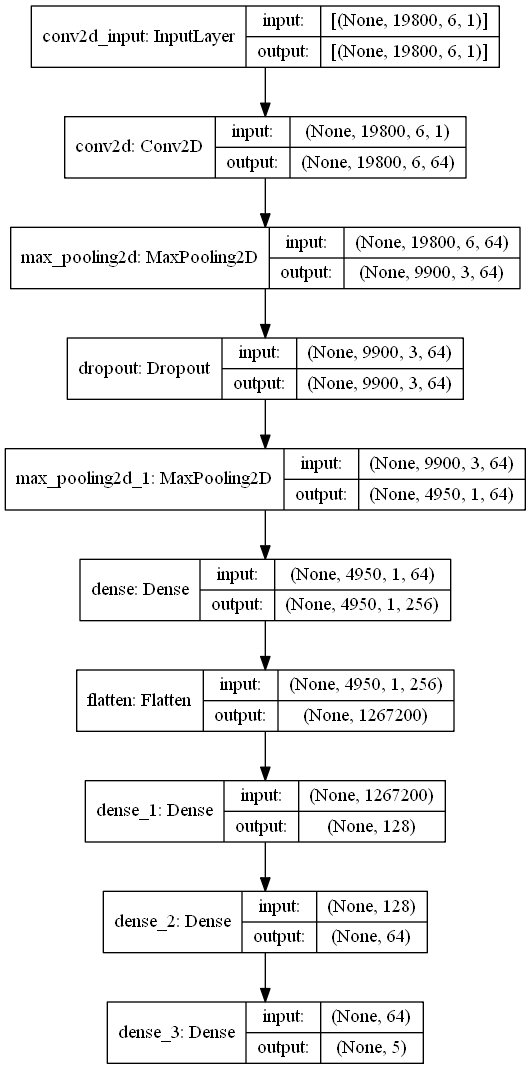

In [53]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [73]:
mod = model.fit(X_train,
               Y_train, epochs=200, batch_size= 32, verbose=2 , 
                callbacks=[callback, print_weights])

Epoch 1/200
5/5 - 28s - loss: 0.0093 - sparse_categorical_accuracy: 0.9932
Epoch 2/200
5/5 - 28s - loss: 0.0111 - sparse_categorical_accuracy: 0.9932
Epoch 3/200
5/5 - 28s - loss: 0.0105 - sparse_categorical_accuracy: 1.0000
Epoch 4/200
5/5 - 28s - loss: 0.0123 - sparse_categorical_accuracy: 0.9932
Epoch 5/200
5/5 - 29s - loss: 0.0091 - sparse_categorical_accuracy: 1.0000
Epoch 6/200
5/5 - 27s - loss: 0.0076 - sparse_categorical_accuracy: 0.9932
Epoch 7/200
5/5 - 27s - loss: 0.0048 - sparse_categorical_accuracy: 1.0000
Epoch 8/200
5/5 - 27s - loss: 0.0076 - sparse_categorical_accuracy: 1.0000
Epoch 9/200
5/5 - 27s - loss: 0.0024 - sparse_categorical_accuracy: 1.0000
Epoch 10/200
5/5 - 27s - loss: 0.0102 - sparse_categorical_accuracy: 0.9932
Epoch 11/200
5/5 - 30s - loss: 4.9303 - sparse_categorical_accuracy: 0.8493
Epoch 12/200
5/5 - 28s - loss: 0.0041 - sparse_categorical_accuracy: 1.0000
Epoch 13/200
5/5 - 28s - loss: 0.0025 - sparse_categorical_accuracy: 1.0000
Epoch 00013: early st

In [74]:
len(wie_by_epoch)

48

In [75]:
#model.set_weights(wie_by_epoch[76])

In [76]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 1s - loss: 0.3378 - sparse_categorical_accuracy: 0.9459


[0.3377852737903595, 0.9459459185600281]

In [77]:
dict(zip(model.metrics_names, scores))

{'loss': 0.3377852737903595, 'sparse_categorical_accuracy': 0.9459459185600281}

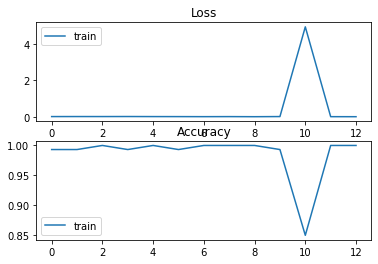

In [78]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [79]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [80]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [81]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.945946
Precision: 0.958333
Recall: 0.933333
F1 score: 0.942547


In [82]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.885449
[[22  0]
 [ 2 13]]


In [83]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


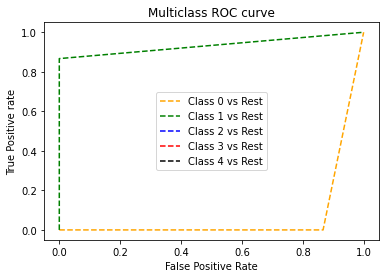

In [84]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [86]:
matrix = confusion_matrix(Y_test, yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 2 13]]


In [87]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      0.87      0.93        15

    accuracy                           0.95        37
   macro avg       0.96      0.93      0.94        37
weighted avg       0.95      0.95      0.95        37



In [88]:
model.save('./models/CFS feature selection/Without IP_Top 6/Binary/CNN')

INFO:tensorflow:Assets written to: ./models/CFS feature selection/Without IP_Top 6/Binary/CNN\assets


In [ ]:
#FOr DNN model

In [47]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
#model_check = ModelCheckpoint("/models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [48]:
model = Sequential()
model.add(Flatten(input_shape = X_train.shape[1:], name = 'input'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(5, activation = 'softmax') )
#mod1 = model.compile(optimizer=tf.keras.optimizers.RMSprop(
#   learning_rate=0.1, rho=0.1, momentum=0.0, epsilon=1e-2 , centered=False,
#   name='RMSprop'), loss='sparse_categorical_crossentropy', metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])
#mod = model.fit(X.astype('float32'),Y.astype('float32'), epochs=20, batch_size= 20, verbose=0)

In [49]:
model.build(input_shape = (nx,ny))
model.output_shape

(None, 5)

In [50]:
#del model, wie_by_epoch

gc.collect()

202

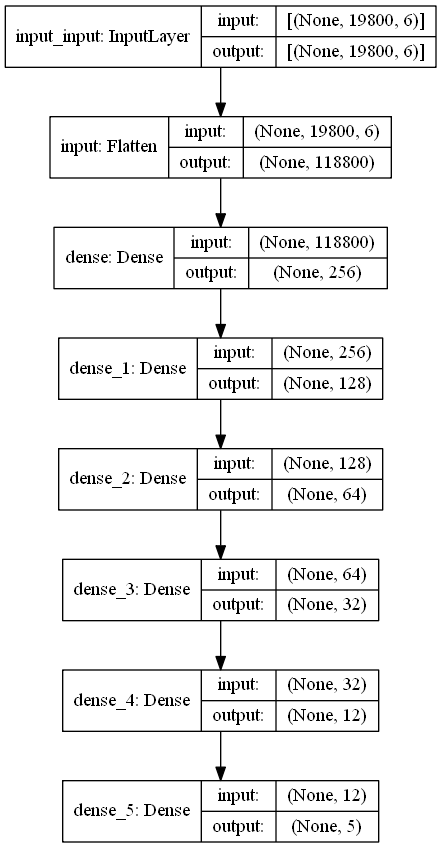

In [51]:
wights = model.get_weights()
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [52]:
mod = model.fit(X_train,
               Y_train, epochs=40, batch_size= 32, verbose=2 , 
                callbacks=[callback, print_weights])

Epoch 1/40
5/5 - 2s - loss: 1.7122 - sparse_categorical_accuracy: 0.4932
Epoch 2/40
5/5 - 1s - loss: 0.1262 - sparse_categorical_accuracy: 0.9932
Epoch 3/40
5/5 - 1s - loss: 0.0652 - sparse_categorical_accuracy: 0.9932
Epoch 4/40
5/5 - 1s - loss: 0.0452 - sparse_categorical_accuracy: 0.9932
Epoch 5/40
5/5 - 1s - loss: 0.0369 - sparse_categorical_accuracy: 0.9932
Epoch 6/40
5/5 - 1s - loss: 0.0322 - sparse_categorical_accuracy: 0.9932
Epoch 7/40
5/5 - 1s - loss: 0.0286 - sparse_categorical_accuracy: 0.9932
Epoch 8/40
5/5 - 1s - loss: 0.0263 - sparse_categorical_accuracy: 0.9932
Epoch 9/40
5/5 - 1s - loss: 0.0242 - sparse_categorical_accuracy: 0.9932
Epoch 10/40
5/5 - 1s - loss: 0.0221 - sparse_categorical_accuracy: 0.9932
Epoch 11/40
5/5 - 1s - loss: 0.0205 - sparse_categorical_accuracy: 0.9932
Epoch 12/40
5/5 - 1s - loss: 0.0181 - sparse_categorical_accuracy: 1.0000
Epoch 13/40
5/5 - 1s - loss: 0.0157 - sparse_categorical_accuracy: 0.9932
Epoch 14/40
5/5 - 1s - loss: 0.0137 - sparse_ca

In [56]:
#Total Epochs
len(wie_by_epoch)

17

In [54]:
#
#model.set_weights(wie_by_epoch[37])

In [55]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 0s - loss: 4.6715e-06 - sparse_categorical_accuracy: 1.0000


[4.6715131247765385e-06, 1.0]

In [56]:
dict(zip(model.metrics_names, scores))

{'loss': 4.6715131247765385e-06, 'sparse_categorical_accuracy': 1.0}

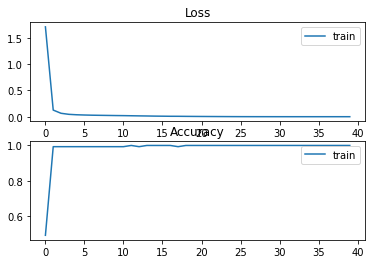

In [57]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [58]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [59]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve


In [60]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


In [61]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 1.000000
[[22  0]
 [ 0 15]]


In [62]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


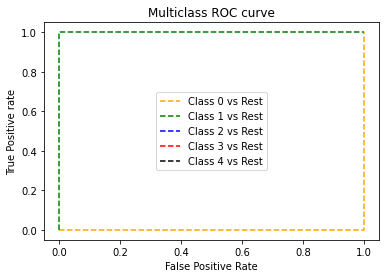

In [63]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [64]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 0 15]]


In [65]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [66]:
model.save('./models/CFS feature selection/Without IP_Top 6/Binary/DNN')

INFO:tensorflow:Assets written to: ./models/CFS feature selection/Without IP_Top 6/Binary/DNN\assets


In [67]:
from keras import backend as K
K.clear_session()

In [68]:
#LSTM

In [69]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
model_check = ModelCheckpoint("./models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [70]:
model = Sequential()
model.add(LSTM(14, activation='relu', return_sequences = True, dropout = 0.1, input_shape = (nx,ny) ))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [71]:
model.build(input_shape = (nx,ny))
model.output_shape

(None, 5)

In [72]:
#del model, wie_by_epoch

gc.collect()

15848

In [73]:
#model.build(input_shape = (nx,ny))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 19800, 14)         1176      
_________________________________________________________________
flatten (Flatten)            (None, 277200)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1386005   
Total params: 1,387,181
Trainable params: 1,387,181
Non-trainable params: 0
_________________________________________________________________


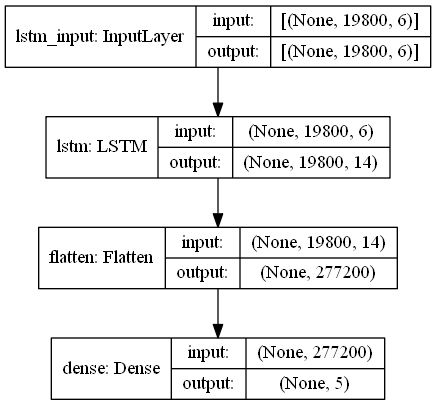

In [74]:
from tensorflow.keras.utils import plot_model
wights = model.get_weights()
plot_model(model, show_shapes=True)

In [75]:
mod = model.fit(X_train,
               Y_train, epochs=200, batch_size= 64, verbose=2 , 
                callbacks=[callback, print_weights, model_check])

Epoch 1/200
3/3 - 31s - loss: 1.1978 - sparse_categorical_accuracy: 0.5411
Epoch 2/200
3/3 - 29s - loss: 0.2578 - sparse_categorical_accuracy: 0.9589
Epoch 3/200
3/3 - 29s - loss: 0.1016 - sparse_categorical_accuracy: 0.9932
Epoch 4/200
3/3 - 30s - loss: 0.0601 - sparse_categorical_accuracy: 0.9932
Epoch 5/200
3/3 - 46s - loss: 0.0461 - sparse_categorical_accuracy: 0.9932
Epoch 6/200
3/3 - 57s - loss: 0.0392 - sparse_categorical_accuracy: 0.9932
Epoch 7/200
3/3 - 45s - loss: 0.0362 - sparse_categorical_accuracy: 0.9932
Epoch 8/200
3/3 - 23s - loss: 0.0329 - sparse_categorical_accuracy: 0.9932
Epoch 9/200
3/3 - 22s - loss: 0.0309 - sparse_categorical_accuracy: 0.9932
Epoch 10/200
3/3 - 23s - loss: 0.0300 - sparse_categorical_accuracy: 0.9932
Epoch 11/200
3/3 - 23s - loss: 0.0295 - sparse_categorical_accuracy: 0.9932
Epoch 12/200
3/3 - 25s - loss: 0.0295 - sparse_categorical_accuracy: 0.9932
Epoch 13/200
3/3 - 23s - loss: 0.0289 - sparse_categorical_accuracy: 0.9932
Epoch 14/200
3/3 - 24

In [76]:
# Number of Epochs
len(wie_by_epoch)

42

In [77]:
# 7
model.set_weights(wie_by_epoch[36])

In [78]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 4s - loss: 0.0243 - sparse_categorical_accuracy: 1.0000


[0.024318061769008636, 1.0]

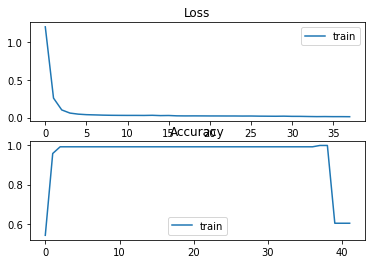

In [79]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [80]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [81]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


In [82]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 1.000000
[[22  0]
 [ 0 15]]


In [83]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


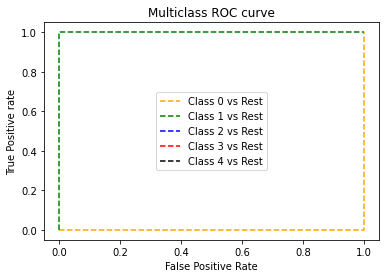

In [84]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [85]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 0 15]]


In [86]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [87]:
import pickle
#filename = './models/CFS feature selection/With IP_ Top 7/Multi-class/KNN/KNN.sav'
model.save('./models/CFS feature selection/Without IP_Top 6/Binary/LSTM')

INFO:tensorflow:Assets written to: ./models/CFS feature selection/Without IP_Top 6/Binary/LSTM\assets


In [88]:
from keras import backend as K
K.clear_session()

In [89]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
model_check = ModelCheckpoint("./models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [90]:
model = Sequential()
model.add(SimpleRNN(16, input_shape=(nx, ny), return_sequences = True, activation='relu'))
model.add(Flatten())
model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [91]:
model.build(input_shape = (nx,ny))
model.output_shape

(None, 5)

In [92]:
#del model, wie_by_epoch

gc.collect()

72719

In [93]:
#model.build(input_shape = (nx,ny))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 19800, 16)         368       
_________________________________________________________________
flatten (Flatten)            (None, 316800)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1584005   
Total params: 1,584,373
Trainable params: 1,584,373
Non-trainable params: 0
_________________________________________________________________


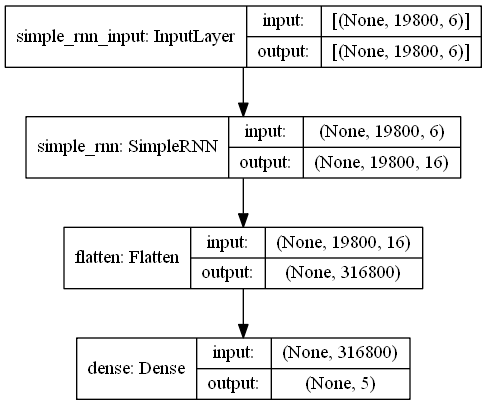

In [94]:
from tensorflow.keras.utils import plot_model
wights = model.get_weights()
plot_model(model, show_shapes=True)

In [95]:
mod = model.fit(X_train,
               Y_train, epochs=120, batch_size= 32, verbose=2 , 
                callbacks=[callback, print_weights, model_check])

Epoch 1/120
5/5 - 30s - loss: 8.2247 - sparse_categorical_accuracy: 0.6370
Epoch 2/120
5/5 - 25s - loss: 0.0636 - sparse_categorical_accuracy: 0.9932
Epoch 3/120
5/5 - 25s - loss: 0.0367 - sparse_categorical_accuracy: 0.9932
Epoch 4/120
5/5 - 26s - loss: 0.0265 - sparse_categorical_accuracy: 0.9932
Epoch 5/120
5/5 - 22s - loss: 0.0240 - sparse_categorical_accuracy: 0.9932
Epoch 6/120
5/5 - 20s - loss: 0.0238 - sparse_categorical_accuracy: 0.9932
Epoch 7/120
5/5 - 20s - loss: 0.0224 - sparse_categorical_accuracy: 0.9932
Epoch 8/120
5/5 - 20s - loss: 0.0239 - sparse_categorical_accuracy: 0.9932
Epoch 9/120
5/5 - 20s - loss: 0.0223 - sparse_categorical_accuracy: 0.9932
Epoch 10/120
5/5 - 19s - loss: 0.0202 - sparse_categorical_accuracy: 0.9932
Epoch 11/120
5/5 - 19s - loss: 0.0209 - sparse_categorical_accuracy: 0.9932
Epoch 12/120
5/5 - 19s - loss: 0.0183 - sparse_categorical_accuracy: 0.9932
Epoch 13/120
5/5 - 17s - loss: 0.0158 - sparse_categorical_accuracy: 0.9932
Epoch 14/120
5/5 - 17

In [96]:
#Number of Epochs
len(wie_by_epoch)

39

In [97]:
#120 +21
#model.set_weights(wie_by_epoch[95])
#mod.history.get('sparse_categorical_accuracy')

In [98]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 2s - loss: 2.3190e-04 - sparse_categorical_accuracy: 1.0000


[0.00023189897183328867, 1.0]

In [99]:
dict(zip(model.metrics_names, scores))

{'loss': 0.00023189897183328867, 'sparse_categorical_accuracy': 1.0}

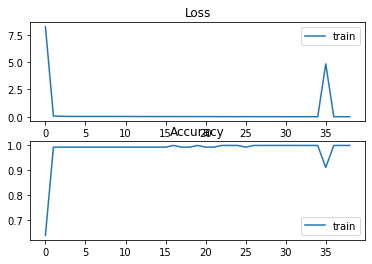

In [100]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [101]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [102]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


In [103]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 1.000000
[[22  0]
 [ 0 15]]


In [104]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


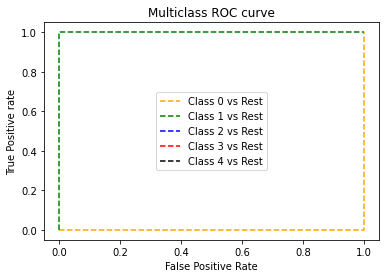

In [105]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [106]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 0 15]]


In [107]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [108]:
import pickle
model.save('./models/CFS feature selection/Without IP_Top 6/Binary/Simple RNN')

INFO:tensorflow:Assets written to: ./models/CFS feature selection/Without IP_Top 6/Binary/Simple RNN\assets


In [109]:
#MLP

In [110]:
#X = make_4D(X)
nsamples,nx, ny = X_test.shape
print(f"samples: {nsamples} \n X:{nx} \n Y:{ny}" )
X_test = X_test.reshape((nsamples,nx*ny))

samples: 37 
 X:19800 
 Y:6


In [111]:
nsamples,nx, ny = X_train.shape
print(f"samples: {nsamples} \n X:{nx} \n Y:{ny}" )
X_train = X_train.reshape((nsamples,nx*ny))

samples: 146 
 X:19800 
 Y:6


In [112]:
from sklearn.neural_network import MLPClassifier

In [113]:
clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1).fit(X_train, Y_train)
y_pred=clf.predict(X_test)


In [114]:
clf.score(X_test, Y_test)

1.0

In [115]:
yhat_classes = y_pred

In [116]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve


In [117]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


In [118]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 1.000000
[[22  0]
 [ 0 15]]


In [119]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


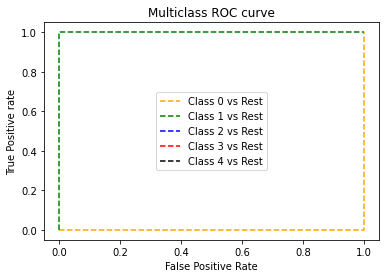

In [120]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [121]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = confusion_matrix(Y_test, yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 0 15]]


In [122]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [124]:
import pickle
# save the model to disk
filename = './models/CFS feature selection/Without IP_Top 6/Binary/MLP/MLP.sav'
pickle.dump(clf, open(filename, 'wb'))

In [125]:
#DBN model
from dbn.tensorflow import SupervisedDBNClassification

Instructions for updating:
non-resource variables are not supported in the long term


In [128]:
classifier = SupervisedDBNClassification(hidden_layers_structure=[32,32],
                                         learning_rate_rbm=0.01,
                                         learning_rate=0.2,
                                         n_epochs_rbm=32,
                                         n_iter_backprop=512,
                                         batch_size=32,
                                         activation_function='relu',
                                         dropout_p=0.01)

In [127]:
del classifier
gc.collect()

57819

In [129]:
classifier.fit(X_train, Y_train)

[START] Pre-training step:
Instructions for updating:
Use `tf.cast` instead.
>> Epoch 1 finished 	RBM Reconstruction error 192152.593750
>> Epoch 2 finished 	RBM Reconstruction error 2438045.250000
>> Epoch 3 finished 	RBM Reconstruction error 4581662.000000
>> Epoch 4 finished 	RBM Reconstruction error 5789245.500000
>> Epoch 5 finished 	RBM Reconstruction error 6191236.500000
>> Epoch 6 finished 	RBM Reconstruction error 6610264.000000
>> Epoch 7 finished 	RBM Reconstruction error 6521947.000000
>> Epoch 8 finished 	RBM Reconstruction error 6252559.000000
>> Epoch 9 finished 	RBM Reconstruction error 6787604.000000
>> Epoch 10 finished 	RBM Reconstruction error 6468719.000000
>> Epoch 11 finished 	RBM Reconstruction error 6048956.000000
>> Epoch 12 finished 	RBM Reconstruction error 6911775.500000
>> Epoch 13 finished 	RBM Reconstruction error 7344086.000000
>> Epoch 14 finished 	RBM Reconstruction error 7488378.000000
>> Epoch 15 finished 	RBM Reconstruction error 7816011.500000
>> 

>> Epoch 69 finished 	ANN training loss 0.671296
>> Epoch 70 finished 	ANN training loss 0.671082
>> Epoch 71 finished 	ANN training loss 0.670365
>> Epoch 72 finished 	ANN training loss 0.669102
>> Epoch 73 finished 	ANN training loss 0.666458
>> Epoch 74 finished 	ANN training loss 0.650023
>> Epoch 75 finished 	ANN training loss 0.545121
>> Epoch 76 finished 	ANN training loss 0.385999
>> Epoch 77 finished 	ANN training loss 0.289847
>> Epoch 78 finished 	ANN training loss 0.226569
>> Epoch 79 finished 	ANN training loss 0.189432
>> Epoch 80 finished 	ANN training loss 0.158344
>> Epoch 81 finished 	ANN training loss 0.136655
>> Epoch 82 finished 	ANN training loss 0.123223
>> Epoch 83 finished 	ANN training loss 0.110556
>> Epoch 84 finished 	ANN training loss 0.100345
>> Epoch 85 finished 	ANN training loss 0.092861
>> Epoch 86 finished 	ANN training loss 0.085458
>> Epoch 87 finished 	ANN training loss 0.080788
>> Epoch 88 finished 	ANN training loss 0.075442
>> Epoch 89 finished

>> Epoch 234 finished 	ANN training loss 0.004220
>> Epoch 235 finished 	ANN training loss 0.004507
>> Epoch 236 finished 	ANN training loss 0.004360
>> Epoch 237 finished 	ANN training loss 0.004303
>> Epoch 238 finished 	ANN training loss 0.004374
>> Epoch 239 finished 	ANN training loss 0.004663
>> Epoch 240 finished 	ANN training loss 0.004509
>> Epoch 241 finished 	ANN training loss 0.004363
>> Epoch 242 finished 	ANN training loss 0.004226
>> Epoch 243 finished 	ANN training loss 0.004517
>> Epoch 244 finished 	ANN training loss 0.004766
>> Epoch 245 finished 	ANN training loss 0.004604
>> Epoch 246 finished 	ANN training loss 0.004455
>> Epoch 247 finished 	ANN training loss 0.005163
>> Epoch 248 finished 	ANN training loss 0.005464
>> Epoch 249 finished 	ANN training loss 0.005250
>> Epoch 250 finished 	ANN training loss 0.006198
>> Epoch 251 finished 	ANN training loss 0.005937
>> Epoch 252 finished 	ANN training loss 0.005698
>> Epoch 253 finished 	ANN training loss 0.006217


>> Epoch 398 finished 	ANN training loss 0.003672
>> Epoch 399 finished 	ANN training loss 0.003808
>> Epoch 400 finished 	ANN training loss 0.003636
>> Epoch 401 finished 	ANN training loss 0.003529
>> Epoch 402 finished 	ANN training loss 0.003429
>> Epoch 403 finished 	ANN training loss 0.003773
>> Epoch 404 finished 	ANN training loss 0.003621
>> Epoch 405 finished 	ANN training loss 0.003482
>> Epoch 406 finished 	ANN training loss 0.003371
>> Epoch 407 finished 	ANN training loss 0.003457
>> Epoch 408 finished 	ANN training loss 0.003358
>> Epoch 409 finished 	ANN training loss 0.003263
>> Epoch 410 finished 	ANN training loss 0.003172
>> Epoch 411 finished 	ANN training loss 0.003087
>> Epoch 412 finished 	ANN training loss 0.003177
>> Epoch 413 finished 	ANN training loss 0.003094
>> Epoch 414 finished 	ANN training loss 0.003184
>> Epoch 415 finished 	ANN training loss 0.003270
>> Epoch 416 finished 	ANN training loss 0.003177
>> Epoch 417 finished 	ANN training loss 0.003264


SupervisedDBNClassification(batch_size=32, dropout_p=0.01,
                            idx_to_label_map={0: 0, 1: 1},
                            l2_regularization=1.0,
                            label_to_idx_map={0: 0, 1: 1}, learning_rate=0.2,
                            n_iter_backprop=512, verbose=True)

In [139]:
# predict probabilities for test set
yhat_probs = classifier.predict(X_test)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = yhat_probs# np.argmax(yhat_probs,axis=1)

In [140]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [141]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


In [142]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 1.000000
[[22  0]
 [ 0 15]]


In [143]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


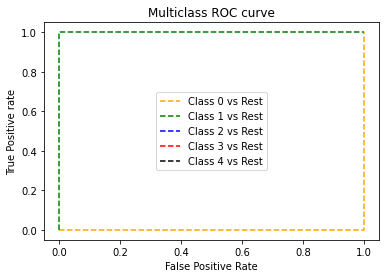

In [144]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [145]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 0 15]]


In [146]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [147]:
classifier.save('./models/CFS feature selection/Without IP_Top 6/Binary/DBN/DBN.pkl')